# **Preprocessing Data:**

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.io.arff import loadarff
from sklearn.metrics import silhouette_score

In [113]:
data1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sem 2/AML/Assignments/Data1.csv', header = None)
data2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sem 2/AML/Assignments/Data2.csv', header = None)

In [114]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

In [115]:
data1.head()

,0,1,2
0,NaN,0.000000,1.000000
1,0.0,1.004939,2.319887
2,1.0,3.412653,-1.637157
3,2.0,7.483318,-1.399250
4,3.0,0.702826,2.038150


In [116]:
data1.shape

(1601, 3)

In [117]:
data1 = data1.drop(data1.columns[[0]], axis=1) 

In [118]:
data1 = data1.drop(0, axis=0) 

In [119]:
data1.shape

(1600, 2)

In [120]:
data1.isnull().sum()

1    0
2    0
dtype: int64

In [121]:
data2.head()

,0,1,2,3
0,NaN,0.000000,1.000000,2.000000
1,0.0,-0.744863,-0.914015,-1.815700
2,1.0,0.039325,1.064930,-1.587150
3,2.0,-0.407660,0.397869,-1.909981
4,3.0,0.033789,0.967298,-1.014872


In [122]:
data2.shape

(2001, 4)

In [123]:
data2 = data2.drop(data2.columns[[0]], axis=1) 

In [124]:
data2 = data2.drop(0, axis=0) 

In [125]:
data2.shape

(2000, 3)

In [126]:
data2.isnull().sum()

1    0
2    0
3    0
dtype: int64

In [127]:
from sklearn.preprocessing import StandardScaler 
St_scaler  = StandardScaler()

data1 = pd.DataFrame(St_scaler.fit_transform(data1),columns=['0','1'])

In [128]:
data2 = pd.DataFrame(St_scaler.fit_transform(data2),columns=['0','1', '2'])

# **1. Apply model based clustering on Data 1**

Gaussian Mixture Model is used to find the clusters in the given dataset.
The value of Prior probabilities, means and variances are intialized first.
Then for each dataset we predict its probability to for its cluster with the given value of mean, variance and prior probability. Then we keep updating our parameters for each datset. I got the optimal result for 4 clusters and 150 iterations. Classified clusters are shown below.

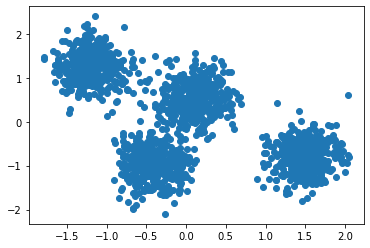

In [129]:
plt.scatter(data1.iloc[:,:1], data1.iloc[:,1:2])
plt.show()

In [130]:
class Gaussian_Mixture:
    def __init__(self, k, max_iter = 150):
        self.k = k
        self.max_iter = int(max_iter)

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape

        # phi is an array that stores prob. of selecting each class = 
        # sum of weights for all the datapoints
        self.phi = np.full(shape=self.k, fill_value=1/self.k) 
        # array of 1*k length with all having same value (1/k).

        # weight = (prob. of Xi belong to class c) / (sum of prob. of Xi 
        # belongs to class c1, c2,.... ck)
        self.weights = np.full( shape=(self.n, self.k), fill_value=1/self.k) 
        # array of n*m length with all having same value (1/k).
        
        random_row = np.random.randint(low=0, high=self.n, size=self.k) 
        # array of 1*k length with having random integer values.
        self.mu = [  X.iloc[row_index,:] for row_index in random_row ]
        self.sigma = [ np.cov(X.T) for _ in range(self.k) ] 
        # covariance matrix of dataset.

    def e_step(self, X):
        # E-Step: update weights and phi holding mu and sigma constant
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)
    
    def m_step(self, X):
        # M-Step: update mu and sigma holding phi and weights constant
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()

            # Updating mean of each class:
            self.mu[i] = (X * weight).sum(axis=0) / total_weight

            # Updating variance of each class:
            self.sigma[i] = np.cov(X.T, aweights=(
                weight/total_weight).flatten(), 
                bias=True)

    def fit(self, X):
        self.initialize(X)
        
        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)

        return self.mu, self.sigma, self.phi    
            
    def predict_proba(self, X):
        likelihood = np.zeros((self.n, self.k)) 
        # array of size n*k to store prob. of Xi to be in each class.
        for i in range(self.k):
            distribution = multivariate_normal(mean=self.mu[i], 
                                               cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(X)
        
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator 
        # weight = (prob. of Xi belong to class c) / (sum of prob. of Xi 
        # belongs to class c1, c2,.... ck)
        return weights
    
    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

In [131]:
model = Gaussian_Mixture(4)

In [132]:
mean, variance, prob = model.fit(data1)

In [134]:
print('Mean of clusters:\n', mean)
print('Variance is:\n', variance)
print('Prior probabilities:\n', prob)

Mean of clusters:
 [0    0.109905
1    0.532872
dtype: float64, 0    1.485429
1   -0.814910
dtype: float64, 0   -1.185729
1    1.251880
dtype: float64, 0   -0.411128
1   -0.987155
dtype: float64]
Variance is:
 [array([[0.05473293, 0.00325903],
       [0.00325903, 0.1341623 ]]), array([[0.04993541, 0.00590034],
       [0.00590034, 0.12675402]]), array([[ 0.050648  , -0.00327039],
       [-0.00327039,  0.12713224]]), array([[ 0.04959038, -0.00274184],
       [-0.00274184,  0.12584083]])]
Prior probabilities:
 [0.25190665 0.24993969 0.25064336 0.2475103 ]


In [65]:
y_pred = model.predict(data1)

In [66]:
data1['Predicted_class'] = model.predict(data1)

In [67]:
data1.head()

,0,1,Predicted_class
0,-1.154036,1.399954,1
1,-0.219916,-1.022500,0
2,1.359377,-0.876855,3
3,-1.271247,1.227478,1
4,-1.432333,1.321481,1


In [68]:
data1['Predicted_class'].value_counts()

2    404
1    400
3    400
0    396
Name: Predicted_class, dtype: int64

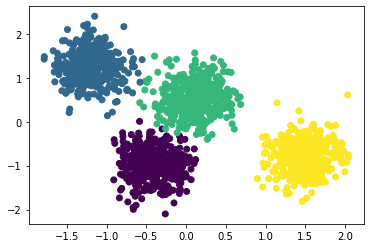

In [69]:
plt.scatter(data1.iloc[:,:1], data1.iloc[:,1:2], c = y_pred)
plt.show()

# **3. Analyse Data 2 using ICA.**

In [70]:
def Independent_component_analysis(X, alpha, max_iter = 500, tolerance = 10**-2):
    weight = np.random.random((X.shape[1], X.shape[1]))
    j = 0
    while j < max_iter:
        weight_update = weight.copy()
        np.random.shuffle(X)
        for i in range(X.shape[0]):
            temp = weight_update@X[i].T
            temp = 1 - 2*sigmoid(temp)
            temp = temp@X[i]
            delta = temp + np.linalg.inv(weight_update.T)
        weight_update = weight_update + alpha*delta
        if np.isclose(weight_update, weight, atol = tolerance).all():
            break 
        weight = weight_update.copy()
        j += 1
    print(f"Total no. of iterations completed: {j}")
    return weight

In [71]:
Weight = Independent_component_analysis(data2.values, 0.05)

Total no. of iterations completed: 249


In [72]:
print('Values of the parameters are: \n', Weight)

Values of the parameters are: 
 [[-1.72382439 -6.28199743 -0.13870576]
 [ 0.33549086 -0.69043571  4.07465746]
 [ 4.04180625 -1.44000067 -2.11973926]]


In [73]:
source = data2.values@Weight
print('Source signals are: \n', source)

Source signals are: 
 [[ 1.65156759 -5.34879954  3.18779174]
 [ 1.99201539 -6.35972502  3.05376479]
 [-0.7461019   3.4055194  -3.00057319]
 ...
 [ 0.55329266  0.15452793 -3.32900427]
 [-0.33182842 -2.75762402  2.36096083]
 [ 1.07635075 -6.13131101  2.8315044 ]]


# **6. Apply model based clustering on ECG data [UCR Time Series Classification and Clustering website].**

In [74]:
ecg, meta = loadarff('/content/drive/MyDrive/Colab Notebooks/Sem 2/AML/Assignments/ECG200_TRAIN.arff') 

In [75]:
df_ecg = pd.DataFrame(ecg)

In [76]:
df_ecg.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,att11,att12,att13,att14,att15,att16,att17,att18,att19,att20,att21,att22,att23,att24,att25,att26,att27,att28,att29,att30,att31,att32,att33,att34,att35,att36,att37,att38,att39,att40,...,att58,att59,att60,att61,att62,att63,att64,att65,att66,att67,att68,att69,att70,att71,att72,att73,att74,att75,att76,att77,att78,att79,att80,att81,att82,att83,att84,att85,att86,att87,att88,att89,att90,att91,att92,att93,att94,att95,att96,target
0,0.502055,0.542163,0.722383,1.428885,2.136516,2.281149,1.936274,1.468890,1.008845,0.380282,-0.296780,-0.513929,-0.255645,-0.107203,-0.287827,-0.418009,-0.319163,-0.260379,-0.350357,-0.505486,-0.710887,-0.823920,-0.899702,-1.153950,-1.229831,-1.044091,-1.202031,-1.392195,-1.130108,-1.179867,-1.649272,-1.726575,-1.608370,-1.662802,-1.650672,-1.697309,-1.838697,-1.802596,-1.780536,-1.825166,...,0.474995,0.532797,0.723550,0.664420,0.647936,0.757054,0.732072,0.620215,0.606297,0.677950,0.689084,0.598807,0.542647,0.581807,0.630631,0.664420,0.686318,0.657383,0.650889,0.721738,0.739706,0.691481,0.695229,0.750115,0.853845,0.916019,0.827750,0.880906,1.088831,0.931043,0.610298,0.638894,0.684679,0.583238,0.640522,0.708585,0.705011,0.713815,0.433765,b'-1'
1,0.147647,0.804668,0.367771,0.243894,0.026614,-0.274402,0.096731,-0.747731,-1.609777,-1.179593,-1.055926,-1.128777,-0.686039,-0.798789,-1.714279,-1.649858,-1.032699,-1.423918,-1.782433,-1.025126,-1.798909,-1.793614,-1.085478,-1.574390,-1.036059,-2.130021,-2.038621,-0.055013,-1.140195,-0.704275,0.048723,-0.475854,0.525865,0.244778,0.679932,0.928601,0.573041,1.231607,1.043324,1.580228,...,0.694075,0.515071,0.559229,0.555712,0.469694,0.388821,0.343129,0.535598,0.900708,0.656846,0.690033,0.952596,0.547770,-0.167693,0.011532,-0.176488,-0.277706,-0.224836,-0.910723,-0.037932,0.071668,-1.048920,-0.636218,-0.386637,-0.507512,-0.716656,-0.463758,-0.460442,-0.770792,-0.533503,-0.400228,0.176084,1.111768,2.438428,2.734889,1.736054,0.036857,-1.265074,-0.208024,b'1'
2,0.316646,0.243199,0.370471,1.063738,1.678187,1.759558,1.697717,1.612159,1.168188,0.499957,-0.022363,-0.235318,-0.118273,-0.071027,-0.322986,-0.433562,-0.318660,-0.295655,-0.417733,-0.682480,-0.881840,-0.843320,-0.883652,-1.030018,-1.055265,-1.168637,-1.363991,-1.337611,-1.261294,-1.409782,-1.634504,-1.703238,-1.677025,-1.782628,-1.996872,-2.056372,-1.937881,-1.879412,-1.915427,-1.845507,...,0.699885,0.732561,0.771665,0.738129,0.723700,0.806876,0.878984,0.855791,0.806384,0.792501,0.803814,0.781938,0.700439,0.735960,0.864162,0.707670,0.458756,0.600146,0.825136,0.800034,0.762821,0.755443,0.653766,0.526441,0.477339,0.574946,0.698425,0.722414,0.771598,0.764229,0.610621,0.552900,0.566786,0.604002,0.777068,0.812345,0.748848,0.818042,0.539347,b'-1'
3,1.168874,2.075901,1.760141,1.606446,1.949046,1.302842,0.459332,0.516412,0.852180,0.989227,0.821253,0.576448,0.743089,0.852970,0.307458,-0.130391,-0.062200,-0.100727,-0.232818,-0.234465,-0.214756,-0.230413,-0.227551,-0.231002,-0.463479,-0.724215,-0.787885,-0.986687,-1.224672,-1.288142,-1.364148,-1.428221,-1.501767,-1.648084,-1.705836,-1.686791,-1.705719,-1.777683,-1.869313,-1.858376,...,0.464974,0.434163,0.486807,0.439388,0.369611,0.413149,0.397895,0.318764,0.263717,0.288863,0.358244,0.326737,0.229215,0.204418,0.244386,0.262632,0.243885,0.227502,0.245785,0.232959,0.164611,0.171538,0.166690,0.099141,0.146937,0.133414,0.125294,0.202713,0.186409,0.419006,0.723888,1.323947,2.136488,1.746597,1.470220,1.893512,1.256949,0.800407,0.731540,b'-1'
4,0.648658,0.752026,2.636231,3.455716,2.118157,0.520620,-0.188627,0.780818,0.933775,0.701402,1.006133,0.395784,-0.369703,-0.738202,-0.729084,-0.906940,-0.870962,-1.060217,-1.197958,-0.981602,-1.272497,-1.287380,-1.276698,-1.539702,-1.346610,-1.535217,-1.763418,-1.688821,-1.809368,-1.863891,-1.994453,-1.889810,-1.925713,-1.833629,-1.661830,-1.342510,-1.011317,-0.672717,-0.216157,0.052872,...,0.453148,0.485785,0.440679,0.539153,0.369571,0.377316,0.470113,0.321448,0.325513,0.251259,0.270571,0.277161,0.

In [77]:
df_ecg['target']= df_ecg['target'].astype("int64")

In [78]:
df_ecg['target'].value_counts()

 1    69
-1    31
Name: target, dtype: int64

In [79]:
X = df_ecg.drop(columns=['target'])
y = df_ecg["target"].astype("int64")

In [80]:
scale = StandardScaler()
X = pd.DataFrame(scale.fit_transform(X))

In [81]:
y = y.replace(-1,0)

In [82]:
y.value_counts()

1    69
0    31
Name: target, dtype: int64

In [83]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,-0.349482,-0.953069,-1.264137,-0.638072,0.615717,1.585020,1.515399,1.300054,0.838954,0.230480,-0.498925,-0.586209,0.146608,0.937357,0.807697,0.736763,1.101256,1.481779,1.489032,1.326902,1.014038,0.932042,0.914535,0.514816,0.474201,1.026123,0.813375,0.340872,0.902744,0.657958,-0.167662,-0.338888,-0.296904,-0.491393,-0.651679,-0.882983,-1.240728,-1.411836,-1.558116,-1.745374,...,0.604079,-0.231666,0.101386,0.813827,0.610508,0.679101,1.300137,1.215311,0.759715,0.705037,0.993472,1.000111,0.834178,0.622042,0.716680,0.916004,0.851548,0.474482,0.188675,0.147039,0.395905,0.676975,0.714293,0.877416,1.107023,1.362650,1.599020,1.480052,1.623973,2.274330,1.843279,1.009694,0.959458,0.678445,0.222294,0.209011,0.384878,0.637480,0.861023,0.629058
1,-0.949627,-0.668763,-1.604575,-1.721992,-1.605352,-1.081781,-0.170376,-1.238330,-2.615990,-1.890414,-1.663838,-1.623974,-0.639384,-0.404853,-2.142936,-1.807948,-0.402557,-1.073970,-1.638673,0.104033,-1.402680,-1.183867,0.489107,-0.424786,0.906532,-1.337166,-1.137901,3.116213,0.883413,1.494333,2.388339,1.435582,2.330749,1.877372,2.122580,2.219654,1.615620,2.082650,1.630849,2.012890,...,0.389974,0.677821,0.023538,0.132826,0.155871,-0.124172,-0.361909,-0.450558,0.381713,1.874221,0.907605,1.003695,2.216293,0.641794,-1.988210,-1.284521,-1.981219,-2.599415,-2.441062,-4.138341,-1.752020,-1.353675,-4.167697,-2.687926,-1.788971,-1.920336,-2.263979,-1.534527,-1.517870,-2.437274,-1.801677,-1.330427,-0.064193,1.406122,2.637173,2.625553,1.625572,-0.371494,-2.347856,-0.930309
2,-0.663448,-1.276861,-1.601983,-0.972075,0.133240,1.040722,1.296784,1.464119,1.049186,0.393197,-0.077831,-0.115960,0.397479,1.007565,0.734969,0.704634,1.102317,1.404294,1.341882,0.910382,0.634317,0.889709,0.951289,0.791778,0.863680,0.755077,0.435618,0.454161,0.651335,0.253629,-0.145432,-0.305778,-0.381431,-0.640188,-1.063780,-1.307232,-1.358197,-1.500304,-1.710447,-1.767822,...,0.570780,0.701942,0.978678,1.013233,0.918777,1.020543,1.525012,1.844550,1.812083,1.499636,1.459543,1.433352,1.549600,1.230356,1.273005,1.746066,0.997245,-0.251123,0.018062,0.625208,0.617282,0.747238,0.893714,0.766385,0.537191,0.454686,0.792022,1.178187,1.252739,1.470578,1.428114,1.010442,0.769255,0.477580,0.249323,0.366562,0.510171,0.703678,1.030033,0.885593
3,0.779690,0.708042,-0.267857,-0.475656,0.418369,0.564125,0.161915,0.209315,0.632253,1.058436,1.216702,1.254170,1.970512,2.800831,2.039051,1.330915,1.642819,1.832459,1.745742,1.964697,2.116047,2.227098,2.453757,2.577423,2.184040,1.722264,1.779336,1.182510,0.721518,0.467545,0.261536,0.084404,-0.165654,-0.473116,-0.717343,-0.870555,-1.083236,-1.383143,-1.658371,-1.782025,...,-0.527595,-0.273265,-0.331783,-0.167317,-0.330621,-0.575213,-0.252105,-0.215994,-0.586930,-0.655433,-0.589601,-0.249193,-0.228693,-0.586282,-0.645291,-0.456865,-0.501955,-0.936264,-1.092722,-0.964650,-0.986091,-1.071154,-0.744196,-0.537904,-0.551400,-0.342098,-0.252666,-0.159588,0.035442,-0.012076,0.568925,1.272738,2.474668,3.152044,1.736624,1.166342,1.815707,1.470956,1.001436,1.352567
4,-0.101230,-0.725777,0.573218,1.215884,0.596391,-0.252149,-0.431880,0.512102,0.739908,0.667093,1.500400,0.949239,-0.061687,-0.287268,-0.105049,-0.273253,-0.061689,-0.275090,-0.362159,0.206457,-0.233413,-0.079246,0.051215,-0.347265,0.213650,-0.042705,-0.496013,-0.274780,-0.399017,-0.544967,-0.687266,-0.570479,-0.687613,-0.703520,-0.664960,-0.463772,-0.260819,-0.110555,0.208527,0.327268,...,0.032322,-0.322362,-0.105077,-0.358488,0.086619,-0.575390,-0.413840,0.093324,-0.574939,-0.410025,-0.742601,-0.580261,-0.422366,-0.871734,-0.946505,-0.165372,0.209918,0.182464,0.310344,0.629721,-0.018519,-0.352001,-0.243688,-0.587811,-0.888570,-0.972003,-0.283588,-0.965796,-0.793592,-0.680585,-0.717472,-0.720365,-1.206200,-0.640503,-0.641421,-0.

In [84]:
X.shape

(100, 96)

In [85]:
from sklearn.neighbors import LocalOutlierFactor 
clf = LocalOutlierFactor(n_neighbors = 7) 
outliers = clf.fit_predict(X)

In [86]:
# Removing the outliers:
X = X.drop(index = np.where(outliers == -1)[0])
y = y.drop(index = np.where(outliers == -1)[0])

In [87]:
means = dict()
means[0] = X.values[np.where(y == 1)[0][0]]
means[1] = X.values[np.where(y == 0)[0][0]]

In [88]:
means

{0: array([-0.94962693, -0.66876315, -1.60457523, -1.72199219, -1.6053524 ,
        -1.08178136, -0.17037579, -1.2383295 , -2.61599002, -1.89041412,
        -1.66383828, -1.62397427, -0.63938441, -0.40485251, -2.14293628,
        -1.80794808, -0.40255727, -1.07396984, -1.63867345,  0.1040326 ,
        -1.40268035, -1.18386686,  0.48910698, -0.42478604,  0.90653173,
        -1.33716569, -1.13790098,  3.11621344,  0.88341326,  1.49433277,
         2.38833932,  1.43558179,  2.33074858,  1.87737164,  2.12257982,
         2.21965378,  1.61562048,  2.08264987,  1.63084923,  2.0128905 ,
         1.5114608 ,  0.7982311 ,  0.90204222,  1.04183052,  1.43136602,
         0.64779716,  0.55594959,  0.27066416,  1.16031806,  1.1835474 ,
         0.16988138,  1.25138908, -0.039197  ,  2.25502421,  1.32687834,
        -2.57662381,  0.38997447,  0.6778206 ,  0.02353845,  0.13282563,
         0.15587066, -0.12417212, -0.36190882, -0.45055832,  0.38171321,
         1.87422137,  0.90760496,  1.00369548,  

In [89]:
from sklearn.mixture import GaussianMixture 
gm = GaussianMixture(n_components = 2, random_state= 0 ).fit(X)

In [135]:
y_pred = gm.fit_predict(X.values)
print('The classified clusters for given datsets are:\n', y_pred)

The classified clusters for given datsets are:
 [1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1
 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1]


# **7. Apply ICA on MEG data. Explain the experimental results obtained.**




In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
import pandas as pd
meg = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sem 2/AML/Assignments/MEG_art.csv', header=None, sep="  ")

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [93]:
meg.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,17690,17691,17692,17693,17694,17695,17696,17697,17698,17699,17700,17701,17702,17703,17704,17705,17706,17707,17708,17709,17710,17711,17712,17713,17714,17715,17716,17717,17718,17719,17720,17721,17722,17723,17724,17725,17726,17727,17728,17729
0,-48.1010,8.9292,-15.4601,-101.8247,-134.0560,-65.4968,32.9820,63.1649,-4.5310,-93.0902,-97.2453,-19.5713,50.0559,76.1131,71.4751,16.0397,-72.4903,-104.0193,-66.7258,-48.0279,-67.3257,-81.3418,-97.1575,-103.7998,-48.4961,15.6885,-5.4820,-47.8084,-25.2333,-19.1909,-76.4552,-77.3769,13.4647,80.0487,85.2718,61.0728,-18.9714,-111.3493,-91.9198,-5.5551,...,30.0985,12.2137,-7.1508,12.3413,24.0008,7.2387,15.8111,71.3533,141.5146,201.8533,225.3764,180.9324,91.9169,12.4178,-49.0179,-101.7792,-122.8021,-99.6871,-56.4678,-12.9423,14.5099,3.8454,-23.4027,-19.6267,-0.6959,-5.4414,3.0035,53.8513,74.2108,25.5571,-7.9927,7.8765,-10.8757,-79.0469,-106.5246,-78.9449,-59.9121,-49.5792,-21.2851,-5.1863
1,-49.9636,-142.8894,-226.2582,-211.3216,-137.6300,-99.0562,-95.9607,-103.6243,-137.4798,-162.0336,-137.9156,-135.5263,-196.0543,-229.3087,-192.2075,-138.2462,-79.0405,-35.7181,-78.2440,-148.8551,-125.0827,-79.0405,-132.5209,-200.4872,-189.6228,-175.6780,-193.2293,-180.4565,-154.9560,-151.1542,-125.8340,-96.6219,-116.6226,-109.9807,-29.6774,-10.0974,-101.3252,-148.6297,-108.3578,-119.2673,...,-155.8232,-180.9554,-200.1026,-195.2219,-162.2056,-152.5768,-161.2781,-116.7116,-26.8277,24.7838,13.3661,-30.4937,-88.0680,-134.0700,-143.2571,-127.7096,-98.1827,-58.3202,-56.6638,-115.3423,-150.0591,-108.8937,-74.2652,-95.0908,-93.1474,-40.5421,-26.0326,-74.9719,-98.6023,-62.0524,-34.8002,-54.7425,-79.1679,-83.1431,-92.9045,-115.0773,-132.7228,-155.8232,-182.6780,-164.2153
2,33.2980,-4.8167,-56.2879,-4.5970,89.8988,85.8677,32.8257,49.0272,69.6223,8.4081,-45.5016,-23.4566,3.3006,17.0087,61.7357,73.3898,1.8287,-33.3422,40.0312,101.0037,71.7971,24.8073,-8.5952,-62.2193,-102.5747,-89.6136,-58.9131,-24.7637,29.4865,51.0373,0.6973,-32.6502,29.7941,122.6313,152.4750,117.4798,65.3714,33.0783,22.0064,1.8507,...,8.5803,11.6654,-71.0705,-86.2310,-53.0902,-89.1835,-124.6797,-84.2737,-64.9167,-101.1759,-105.3061,-85.5841,-106.0359,-136.2076,-133.6864,-98.0907,-27.8282,16.2932,-40.7495,-112.8697,-83.9586,-34.7616,-68.1180,-116.4359,-117.3648,-106.4340,-84.9206,-55.8602,-85.0865,-151.3350,-152.9107,-110.5973,-112.1067,-137.3355,-148.4654,-179.5494,-220.3700,-218.5123,-207.7307,-245.4661
3,-71.7910,-66.8023,-74.1104,-59.1573,28.9549,83.8565,-22.1502,-199.5665,-256.4766,-176.8518,-102.2933,-101.1919,-121.7039,-132.3940,-145.6238,-127.3405,-47.8193,19.2885,8.8057,-18.5091,-16.9153,-53.7798,-145.2998,-199.8127,-195.0314,-198.8280,-216.7743,-202.7671,-157.8169,-109.0443,-83.1678,-102.4229,-123.4662,-82.5588,-29.2898,-39.2932,-58.4575,-30.6893,-16.9023,-38.2306,...,-4.3063,-63.1991,-47.4982,-31.2304,-61.6935,-72.2715,-42.8642,-18.6189,25.1010,113.1859,159.1935,100.1638,10.3778,-25.2668,-16.5658,1.7159,34.4081,78.5972,81.7256,18.5899,-34.1828,-11.0911,23.0088,6.0762,-3.5242,22.7938,25.1205,21.0731,73.0833,124.7611,119.5210,123.6075,151.4310,121.6914,48.2905,3.0651,-35.7470,-82.2825,-77.4921,-30.6242
4,159.5690,61.2882,4.1433,52.4750,139.9503,193.6496,202.4394,161.1277,80.2623,29.0592,55.0534,97.0096,73.6758,13.2846,2.0103,50.8577,102.7640,123.5429,114.7297,95.8494,111.0263,174.5349,210.3970,142.7865,23.7620,-21.0422,53.2251,172.8473,239.2976,225.6442,177.5703,140.9934,134.2429,175.3319,250.1031,273.7650,188.6688,64.3001,-0.5211,-11.3149,...,-24.1174,-68.4195,-86.9501,-72.3904,-105.2731,-174.2307,-166.6264,-77.6848,-7.9486,9.3622,-0.1107,-26.1937,-41.7656,-20.6657,17.2520,68.7172,142.2685,164.9516,78.6313,-16.8765,-14.6186,25.0120,14.5528,-15.6567,-16.6170,6.4814,48.3958,92.2048,86.3653,27.2439,-12.4385,10.9972,52.5224,47.1760,-6.4433,-49.8111,-48.8249,-39.9748,-57.5451,-66.6288


In [94]:
meg.shape

(122, 17730)

In [95]:
meg_data = meg.T
scale = StandardScaler()
meg_data = pd.DataFrame(scale.fit_transform(meg_data))

In [98]:
weights = Independent_component_analysis(meg_data.values, 0.05, 
                                         max_iter = 5, 
                                         tolerance=0.01)
weights

Total no. of iterations completed: 5


array([[-0.84654551, -1.1960477 , -1.17955566, ..., -0.7934657 ,
        -0.6572942 , -1.15823327],
       [-1.10189852, -0.39222131, -0.4727345 , ..., -1.3499575 ,
        -0.49625538, -1.4268522 ],
       [-0.57085434, -0.64611038, -0.6934463 , ..., -1.13082171,
        -1.00344941, -0.89240676],
       ...,
       [-0.83809346, -0.55044769, -1.23472486, ..., -0.57268065,
        -0.93750242, -0.61685897],
       [-1.21999926, -0.72814961, -0.75885874, ..., -0.71641814,
        -0.94441988, -0.80973056],
       [-1.09077439, -0.50835388, -0.94342562, ..., -0.65629853,
        -0.35842335, -1.3027661 ]])

In [99]:
# Getting the source back: 
sources = meg_data.values@weights
sources = pd.DataFrame(sources)

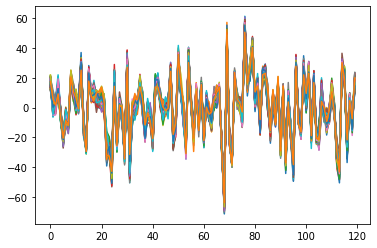

In [109]:
n, m = meg.shape
for i in range(n):
  plt.plot(sources.iloc[:120,i])
plt.show()

In [110]:
print('Source signals are:\n', sources)

Source signals are:
              0          1          2    ...        119        120        121
0      17.763155  16.908514  18.585309  ...  17.034996  15.154053  17.385194
1       0.990901   6.300441   2.946824  ...  -4.495855   0.316022   5.596647
2       0.162641   1.909477   0.368057  ...   3.022266   2.520539   1.628903
3      14.033297  14.146359  12.951212  ...  12.701520  12.730833   9.208556
4      -3.757106  -1.991945  -0.513732  ...  -9.364308  -5.447143  -7.689480
...          ...        ...        ...  ...        ...        ...        ...
17725   4.134934  -0.401092   0.202698  ...   1.785053  -1.700030   2.264204
17726  14.105781  11.550173  10.188105  ...   5.405958   8.308935  11.317613
17727  -3.084120  -2.733921   0.897077  ...  -5.838811  -1.958157   2.535582
17728   0.754319  -3.560336   0.666416  ...  -2.936075   3.033552  -4.891209
17729  27.751308  30.673676  29.604662  ...  28.051246  28.604758  30.648371

[17730 rows x 122 columns]
